In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: tensorflow in c:\users\exact\appdata\local\programs\python\python311\lib\site-packages (2.13.0)




[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.optimizers import Adam
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import ctypes
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.13.0
Hub version: 0.15.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [4]:
import tensorflow as tf
tf.random.set_seed(40)

# training image
train_image_path = r'C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\train'
IMG_SHAPE = 150
training_images =  tf.keras.utils.image_dataset_from_directory(train_image_path,
                                                               image_size=(IMG_SHAPE, IMG_SHAPE),
                                                               shuffle=True, seed = 0, batch_size = 64)

validation_image_path = r'C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\valid'
validation_images =  tf.keras.utils.image_dataset_from_directory(validation_image_path,
                                                               image_size=(IMG_SHAPE, IMG_SHAPE),
                                                               shuffle=False, seed = 0, batch_size = 16
                                                               )

test_image_path = r'C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test'
test_images =  tf.keras.utils.image_dataset_from_directory(test_image_path,
                                                               image_size=(IMG_SHAPE, IMG_SHAPE),
                                                               shuffle=False,seed = 0, batch_size = 32
                                                               )

Found 10500 files belonging to 7 classes.
Found 3500 files belonging to 7 classes.
Found 2249 files belonging to 7 classes.


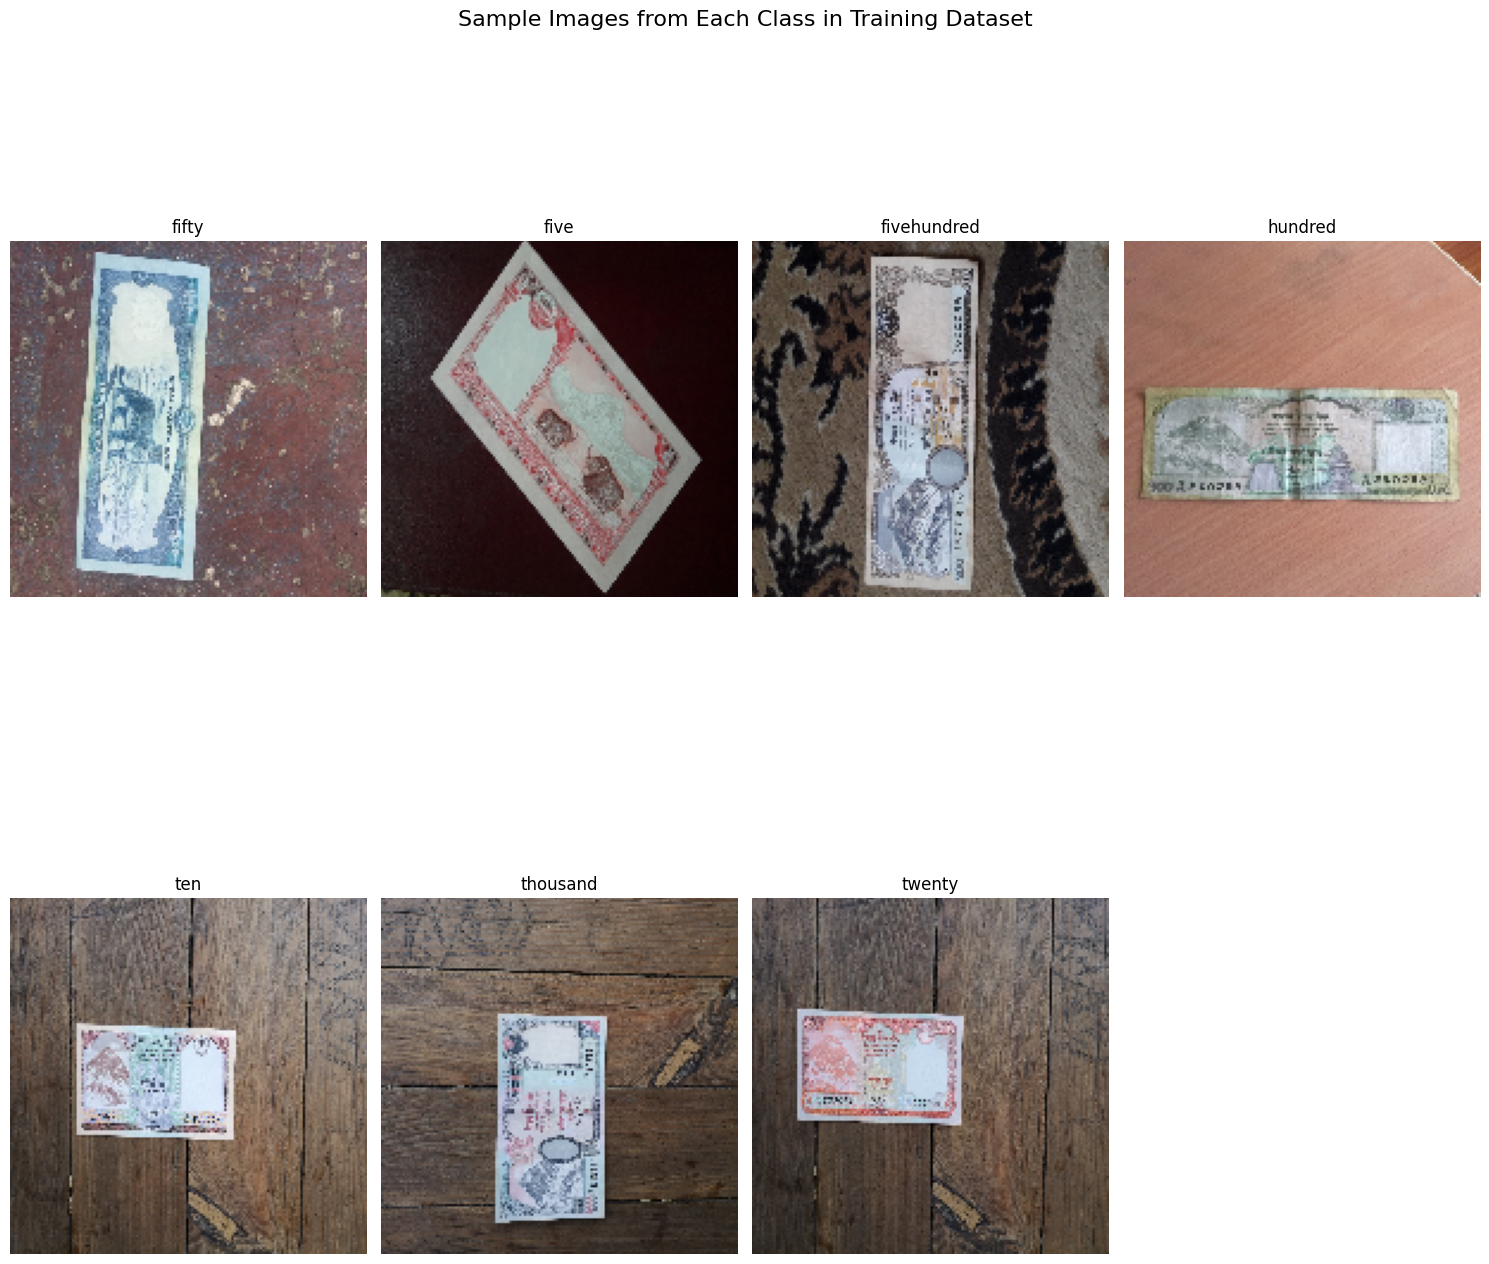

In [3]:

training_image_directory = r'C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\train'

class_directories = [os.path.join(training_image_directory, d) for d in os.listdir(training_image_directory) if os.path.isdir(os.path.join(training_image_directory, d))]

num_classes = len(class_directories)
num_cols = 4 
num_rows = (num_classes + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

fig.suptitle("Sample Images from Each Class in Training Dataset", fontsize=16)

for i, class_dir in enumerate(class_directories):
    ax = axes[i // num_cols, i % num_cols]
    
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    if image_files:
        img_path = os.path.join(class_dir, image_files[0])
        img = image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))
        ax.imshow(img)
        ax.set_title(os.path.basename(class_dir))
        ax.axis('off')  
    else:
        ax.axis('off')


for i in range(num_classes, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


In [5]:
data_augmentation = Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(30),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.5)
])

training_images = tf.keras.utils.image_dataset_from_directory(
    train_image_path,
    image_size=(IMG_SHAPE, IMG_SHAPE),
    shuffle=True,
    seed=0,
    batch_size=64
)


train_images = training_images.map(lambda x, y: (data_augmentation(x), y))


validation_images = tf.keras.utils.image_dataset_from_directory(
    validation_image_path,
    image_size=(IMG_SHAPE, IMG_SHAPE),
    shuffle=False,
    seed=0,
    batch_size=16
)

data_rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

validation_images = validation_images.map(lambda x, y: (data_rescale(x), y))


Found 10500 files belonging to 7 classes.
Found 3500 files belonging to 7 classes.


In [6]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


for layer in pre_trained_model.layers:
    layer.trainable = False
    

In [6]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [7]:

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [8]:

x = tf.keras.layers.GlobalAveragePooling2D()(last_output)

x = tf.keras.layers.Dense(1024, activation='relu')(x)

x = tf.keras.layers.Dropout(0.3)(x) 

x = tf.keras.layers.Dense(49, activation='relu')(x)

x = tf.keras.layers.Dense  (7, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

optimizer = Adam(learning_rate = 0.0001)

model.compile(optimizer = optimizer, 
            loss = 'sparse_categorical_crossentropy', 
            # loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

In [11]:
# Define callbacks
model_check_point = tf.keras.callbacks.ModelCheckpoint('currencydetection_final_model.h5', monitor='val_accuracy',save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping('val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
callbacks = [early_stop, model_check_point, reduce_lr]

In [12]:
#training the CNN model
history = model.fit(
            train_images,
            validation_data = validation_images,
            epochs = 50,
            verbose = 1, 
            callbacks = callbacks)

Epoch 1/50
165/165 [==============================] - ETA: 0s - loss: 1.3910 - accuracy: 0.6327

c:\Users\exact\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


165/165 [==============================] - 200s 1s/step - loss: 1.3910 - accuracy: 0.6327 - val_loss: 0.9875 - val_accuracy: 0.7829 - lr: 1.0000e-04
Epoch 2/50
165/165 [==============================] - 213s 1s/step - loss: 0.7941 - accuracy: 0.8028 - val_loss: 0.6494 - val_accuracy: 0.8331 - lr: 1.0000e-04
Epoch 3/50
165/165 [==============================] - 218s 1s/step - loss: 0.5491 - accuracy: 0.8591 - val_loss: 0.4791 - val_accuracy: 0.8666 - lr: 1.0000e-04
Epoch 4/50
165/165 [==============================] - 248s 1s/step - loss: 0.4307 - accuracy: 0.8846 - val_loss: 0.3769 - val_accuracy: 0.8957 - lr: 1.0000e-04
Epoch 5/50
165/165 [==============================] - 289s 2s/step - loss: 0.3511 - accuracy: 0.9043 - val_loss: 0.3250 - val_accuracy: 0.9123 - lr: 1.0000e-04
Epoch 6/50
165/165 [==============================] - 247s 1s/step - loss: 0.2994 - accuracy: 0.9177 - val_loss: 0.3026 - val_accuracy: 0.9114 - lr: 1.0000e-04
Epoch 7/50
165/165 [==============================]

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

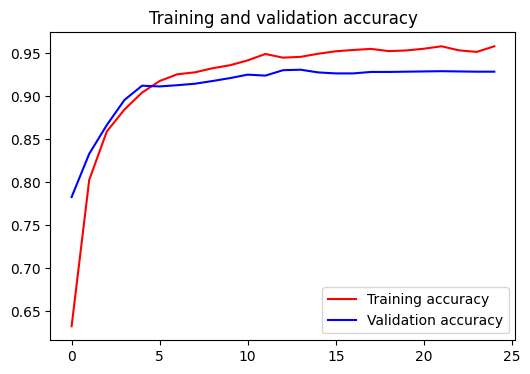

In [14]:
plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('train_val_acc.png', dpi = 400)
plt.show()

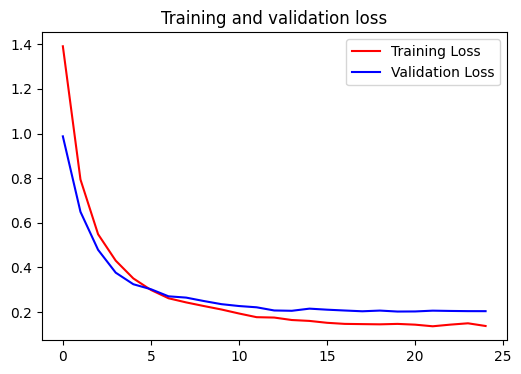

In [15]:
plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('train_val_loss.png', dpi = 400)
plt.show()

In [16]:
model.save('currency_detection_final_model.h5')

In [3]:
from keras.models import load_model
loaded_model = load_model('currency_detection_final_model.h5')

In [18]:


import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('currency_detection_final_model.h5')


def preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 
    return img_array


new_image_paths = [
    r"C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\thousand\thousand_test_150.jpg",
    r"C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\hundred\hundred_test_39.jpg",
    r"C:\Users\exact\Downloads\20230808_140757.jpg",
    r"C:\Users\exact\Downloads\20230808_140643.jpg",
    r"C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\fifty\fifty_test_8.jpg",
    r"C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\ten\ten_test_18.jpg",
    r"C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\twenty\twenty_test_20.jpg",
    r"C:\Users\exact\Downloads\20230808_141026.jpg",
    r"C:\Users\exact\Downloads\20230808_135942.jpg",
    r"C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\five\five_test_15.jpg",
    r"C:\Users\exact\Downloads\20230808_141049.jpg",
    r"C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\fifty\fifty_test_13.jpg",
    r"C:\Users\exact\Downloads\20230808_140642.jpg",
  
]


train_image_path = r'C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\train'


training_dataset = tf.keras.utils.image_dataset_from_directory(
    train_image_path,
    shuffle=False,  
    batch_size=1 
)


class_names = training_dataset.class_names


for image_path in new_image_paths:
  
    processed_image = preprocess_image(image_path)

    
    predictions = model.predict(processed_image)

   
    predicted_class_index = np.argmax(predictions)


    predicted_class_name = class_names[predicted_class_index]

    print(f"Image: {image_path}, Predicted Class: {predicted_class_name}")


Found 10500 files belonging to 7 classes.
1/1 [==============================] - 1s 1s/step
Image: C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\thousand\thousand_test_150.jpg, Predicted Class: thousand
1/1 [==============================] - 0s 52ms/step
Image: C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\hundred\hundred_test_39.jpg, Predicted Class: hundred
1/1 [==============================] - 0s 51ms/step
Image: C:\Users\exact\Downloads\20230808_140757.jpg, Predicted Class: hundred
1/1 [==============================] - 0s 50ms/step
Image: C:\Users\exact\Downloads\20230808_140643.jpg, Predicted Class: hundred
1/1 [==============================] - 0s 48ms/step
Image: C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test\fifty\fifty_test_8.jpg, Predicted Class: hundred
1/1 [==============================] - 0s 47ms/step
Image: C:\Users\exact\OneDrive\

In [8]:
import tensorflow as tf


converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()


with open('currency_detection_final_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\exact\AppData\Local\Temp\tmp_leuj9u7\assets


INFO:tensorflow:Assets written to: C:\Users\exact\AppData\Local\Temp\tmp_leuj9u7\assets


In [9]:
test_images_scaled = test_images.map(lambda x, y: (data_rescale(x), y))

In [10]:
import tensorflow as tf
model = tf.keras.models.load_model('currency_detection_final_model.h5')

In [11]:
scores = model.evaluate(test_images_scaled)
print("%s%s: %.2f%%" % ("evaluate_generator ",model.metrics_names[1], scores[1]*100))

282/282 [==============================] - 60s 205ms/step - loss: 0.2391 - accuracy: 0.9204
evaluate_generator accuracy: 92.04%


In [12]:
import numpy as np
predictions = model.predict(test_images_scaled)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_images], axis=0)

282/282 [==============================] - 57s 192ms/step


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predicted_labels)

In [23]:
cm

array([[138,   0,   0,   6,   5,   0,   0],
       [  0, 129,   0,   0,   0,   0,   1],
       [  0,   1, 143,   0,   3,   4,   0],
       [ 24,   0,  11, 595,  17,   6,   8],
       [ 11,   8,  28,   2, 443,  13,   8],
       [  0,   0,   9,   2,   0, 149,   0],
       [  2,   3,   0,   4,   3,   0, 473]], dtype=int64)

In [14]:
cm


array([[138,   0,   0,   6,   5,   0,   0],
       [  0, 129,   0,   0,   0,   0,   1],
       [  0,   1, 143,   0,   3,   4,   0],
       [ 24,   0,  11, 595,  17,   6,   8],
       [ 11,   8,  28,   2, 443,  13,   8],
       [  0,   0,   9,   2,   0, 149,   0],
       [  2,   3,   0,   4,   3,   0, 473]], dtype=int64)

In [24]:
predicted_labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [25]:
true_labels

array([0, 0, 0, ..., 6, 6, 6])

In [26]:
test_images.class_names

['fifty', 'five', 'fivehundred', 'hundred', 'ten', 'thousand', 'twenty']

In [27]:
class_names = test_images.class_names

In [28]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi = 500)
    plt.show()

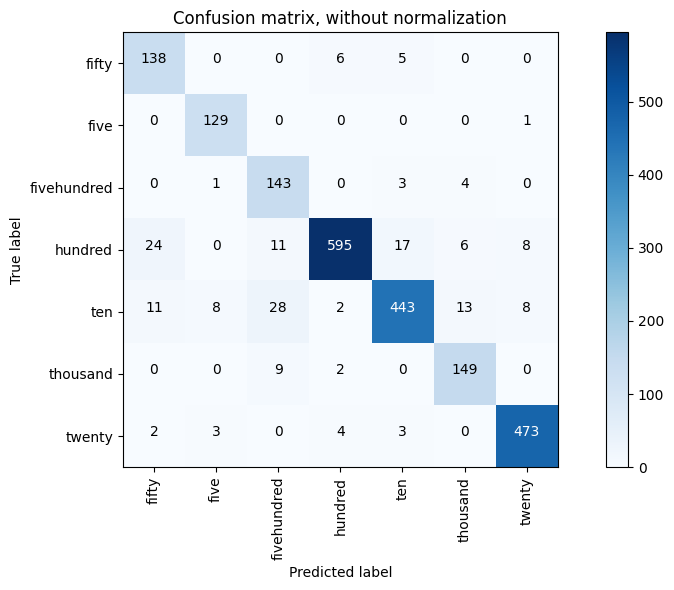

In [29]:

plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [31]:
precision = precision_score(true_labels, predicted_labels, average ='micro')
recall    = recall_score(true_labels, predicted_labels, average ='micro')
f1        = f1_score(true_labels, predicted_labels, average ='micro')

print(f"Precision = {round(precision * 100, 2)}%")
print(f"Recall = {round(recall * 100, 2)}%")
print(f"F1-score = {round(f1 * 100, 2)}%")

Precision = 92.04%
Recall = 92.04%
F1-score = 92.04%


1/1 [==============================] - 0s 301ms/step


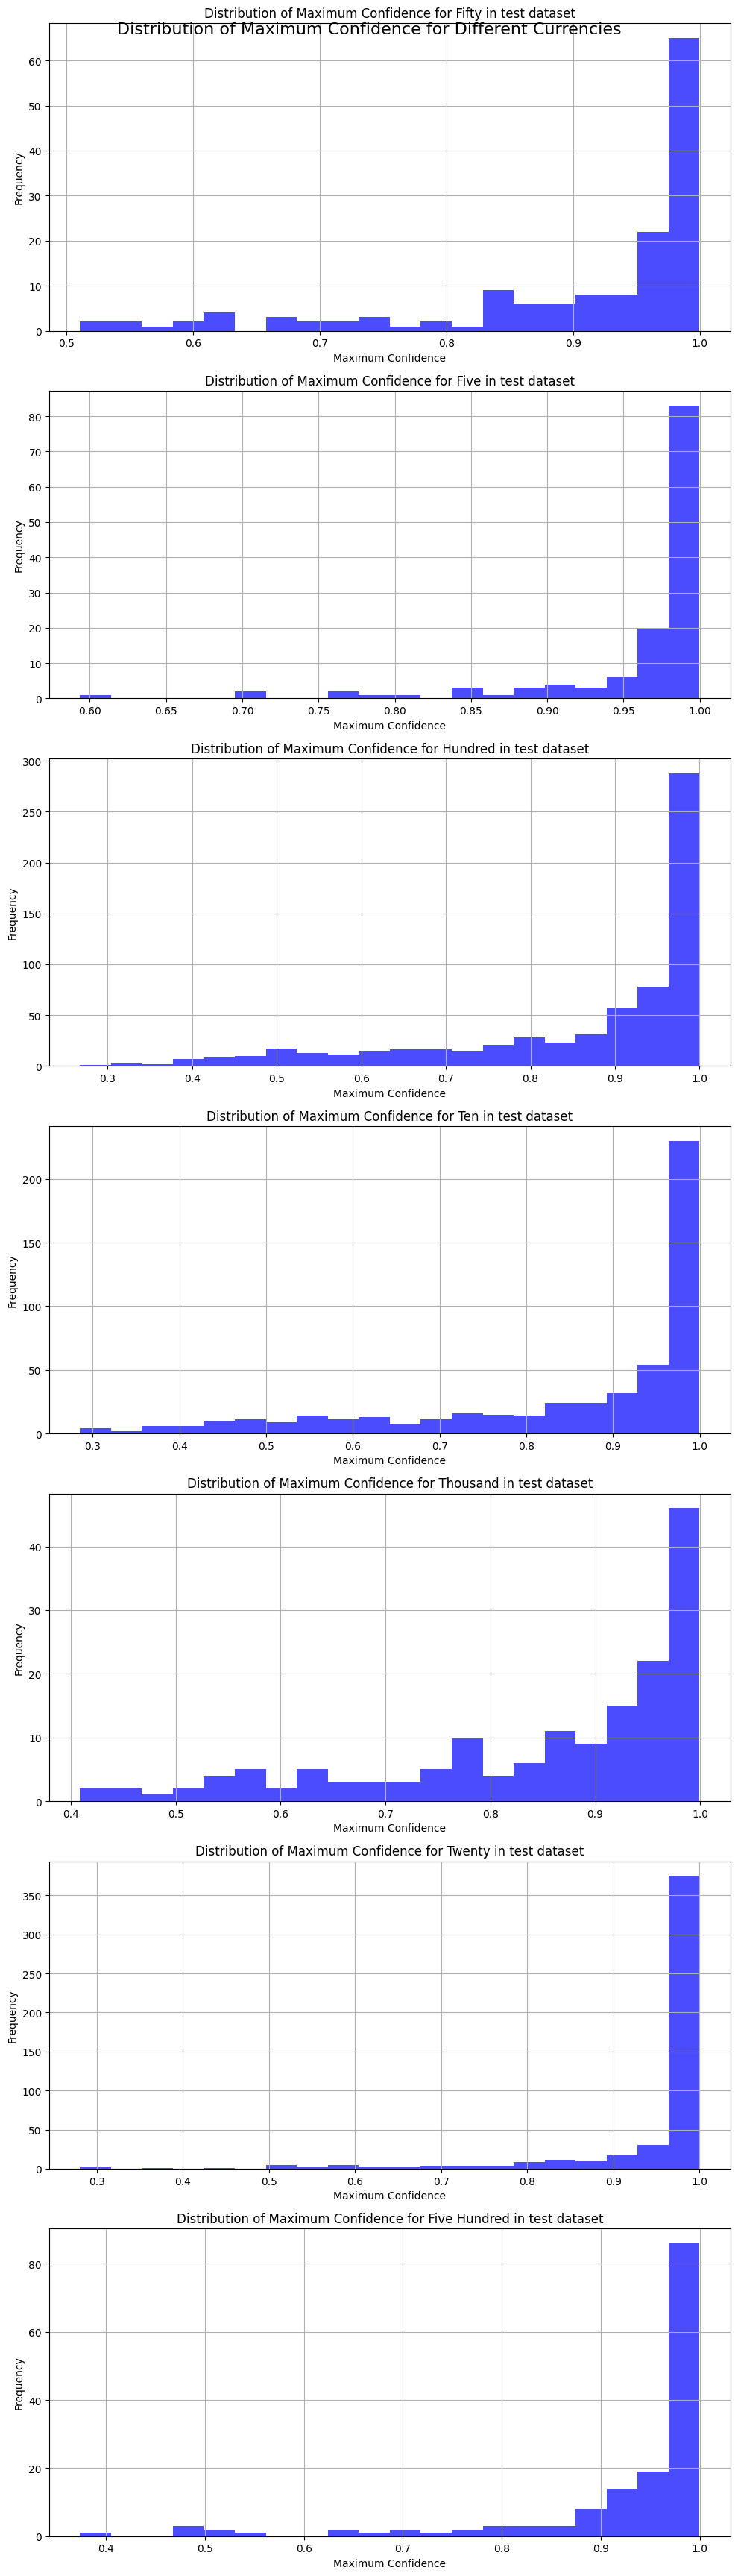

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image

def load_and_preprocess_image(img_path, img_shape=(150, 150)):
    img = image.load_img(img_path, target_size=img_shape)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  
    return img_array

model = tf.keras.models.load_model('currencydetection_final_model.h5')

test_root_dir = r'C:\Users\exact\OneDrive\Desktop\nepali_currency_recognition_tensorflow\currency_dataset\test'


currencies = {
    'Fifty': 'fifty',
    'Five': 'five',
    'Hundred': 'hundred',
    'Ten': 'ten',
    'Thousand': 'thousand',
    'Twenty': 'twenty',
    'Five Hundred': 'fivehundred'
}


num_currencies = len(currencies)
fig, axs = plt.subplots(num_currencies, 1, figsize=(10, 5*num_currencies))
fig.suptitle('Distribution of Maximum Confidence for Different Currencies', fontsize=16)


for i, (currency, dir_name) in enumerate(currencies.items()):
    test_dir = os.path.join(test_root_dir, dir_name)
    image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    max_confidences = []
    
    for image_file in image_files:
        img_path = os.path.join(test_dir, image_file)
        img_array = load_and_preprocess_image(img_path)
        predictions = model.predict(img_array)  
        max_confidence = np.max(predictions)
        max_confidences.append(max_confidence)
    

    axs[i].hist(max_confidences, bins=20, color='blue', alpha=0.7)
    axs[i].set_title(f'Distribution of Maximum Confidence for {currency} in test dataset')
    axs[i].set_xlabel('Maximum Confidence')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [29]:
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

def load_and_preprocess_image(img_path, img_shape=(150, 150)):
    img = image.load_img(img_path, target_size=img_shape)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0 
    return img_array


model = tf.keras.models.load_model('currencydetection_final_model.h5')


image_path = r"C:\Users\exact\OneDrive\Desktop\download.jpg"  
img_array = load_and_preprocess_image(image_path)

predictions = model.predict(img_array)

for i, confidence in enumerate(predictions[0]):
    class_name = f"Class {i}"
    print(f"{class_name}: {confidence}")


1/1 [==============================] - 2s 2s/step
Class 0: 0.2046993374824524
Class 1: 0.0030095952097326517
Class 2: 0.00049364980077371
Class 3: 0.17506031692028046
Class 4: 0.020398922264575958
Class 5: 0.0006916054408065975
Class 6: 0.5956465005874634
